# Ансамбли моделей
## Предисловие
Как Вы уже знаете, модели МО можно использовать не только "как есть", но ещё и строить разнообразные надстройки над ними. Хорошей идеей такой надстройки было и остаётся объединение моделей в ансамбль.

Сама суть ансамблей заключается в том, чтобы объединить предсказания стандартных моделей для повышения обощающей способности или надёжности ансамбля перед одиночным стандартным методом МО.

Ансамбли делятся на два типа:

- Голосующие (или усредняющие) - смысл их заключается в том, чтобы сначала обучить независимые друг от друга модели, а затем голосованием этих моделей выбирать предсказание (или усреднять предсказания по всем моделям, зависит от задачи). Обычно, качество предсказания у ансамблей лучше потому, что у них понижена дисперсия.

    Примеры: [Бэггинг](https://scikit-learn.org/stable/modules/ensemble.html#bagging), [Случайный лес](https://scikit-learn.org/stable/modules/ensemble.html#forest)

- Бустинг-ансамбли - последовательности стандартных моделей, построенные так, чтобы каждая последующая добавленная и натренированная модель каким-то образом исправляла ошибки всей предшествующей ей последовательности моделей. "Объединение слабых моделей даёт сильную модель".

    Примеры: [AdaBoost](https://scikit-learn.org/stable/modules/ensemble.html#adaboost), [Градиентный бустинг](https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting)

Полная [документация](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble) по доступным в sklearn ансамблям.
[Урок](https://habr.com/ru/company/ods/blog/327250/) про бустинг из курса хабра.


## Задача
На этом воркшопе мы будем реализовывать алгоритм градиентного бустинга. Напомню, что в общем смысле бустинг заключается в том, чтобы тренировать каждую последующую модель так, чтобы она исправляла ошибки предыдущих.

Прежде чем мы приступим к реализации, давайте вспомним, как он устроен:
Краткое описание [оригинального алгоритма](https://statweb.stanford.edu/~jhf/ftp/stobst.pdf) (который придумал Фридман):
Для работы алгоритма помимо данных нужно подать:
1. количество итераций $M \in \mathbb{N}$;
2. функцию потерь $L(y,f)$, где $y$ - истинные значения, $f$ - полученная аппроксимация искомой функции (в данном случае это будет не функция, а просто предсказанные значения).
Важно, чтобы функция потерь была дифференцируемой по $f$;
3. базовая модель, на основе которой мы будем делать бустинг - в данном воркшопе мы воспользуемся деревьями решений;
4. Начальное приближение $f_0(x)$ - чаще всего для этого используют некую константу.

**Сам алгоритм:**
1. Задаём начальное приближение функции $f(x) = f_0(x)$ константой - в данном случае можно выбрать ноль, среднее по столбцу с целевым признаком или что-нибудь ещё.
2. Далее итеративно $t$ от 1 до $M$: 
    1. Считаем остатки как $\large r_{t} = -\left[\frac{\partial L(y, f(x))}{\partial f(x)}\right]_{f(x)=\hat{f}(x)}$
    2. Обучаем ещё одну базовую модель $h_t(x)$, при этом нецелевыми признаками у нас будет $x$, а в качестве целевого будем использовать остатки $r_t$, полученные на текущем шаге
    3. Найти оптимальный коэффициент $\rho_t = \underset{\rho}{\arg\min} \ L(y, \hat{f}(x) + \rho \cdot h(x))$ 
    4. обновить текущее приближение $\hat{f}(x) \leftarrow \hat{f}(x) + \hat{f}_i(x)$, где $\hat{f}_i(x) = \rho_t \cdot h_t(x)$
3. Собрать все полученные базовые алгоритмы в модель $\hat{f}(x) = \sum_{i = 0}^M \hat{f_i}(x)$

**Функции потерь:**
- $L(y, f) = (y - f)^2$ - L2-loss. Используйте его если считаете, что у модели нет никаких дополнительных требований к стабильности.
- $L(y, f) = |y - f|$ - L1-loss. Применять при требованиях к стабильности модели. Из минусов можно выделить то, что её немного сложнее дифференцировать (придётся искать производные на разных кусках)
- $\begin{equation} L(y, f) =\left\{ \begin{array}{@{}ll@{}} (1 - \alpha) \cdot |y - f|, & \text{if}\ y-f \leq 0 \\ \alpha \cdot |y - f|, & \text{if}\ y-f >0 \end{array}\right. \end{equation}, \alpha \in (0,1)$ - Lq-loss. Применять при наличии особых требований к модели, например, когда нам нужно восстановить не среднее и не медиану условного распределения $(y|x)$, а какую-нибудь квантиль. Штрафует наблюдения, попадающие выше $\alpha$-той квантили.

**Замечание:**
1. коэффициенты $\rho_i$ искать не обязательно, их можно считать равными единице
2. функций потерь для регрессии бывает 3 вида, Вам достаточно реализовать хотя бы одну из них (конечно, будет здорово, если вы реализуете их все) и посчитать для неё градиент, тоже в виде функции.

## Реализация алгоритма

Как обычно, сначала импортируем всё, что нам нужно.

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor

Теперь реализуйте функции потерь. Как я писал ранее, достаточно реализовать L2 loss или одну любую другую. Остальные - как дополнительное задание. Описания даны выше.

In [7]:
def l2_loss(y_real, y_predicted):
    return np.mean((y_real - y_predicted) ** 2)

def l2_loss_gradient(y_real, y_predicted):
    return -2 * (y_real - y_predicted)

def l1_loss(y_real, y_predicted):
    return np.mean(np.abs(y_real - y_predicted))

def l1_loss_gradient(y_real, y_predicted):
    return np.sign(y_predicted - y_real)

def lq_loss(y_real, y_predicted, alpha=0.5):
    diff = y_real - y_predicted
    return np.mean(np.where(diff <= 0, (1 - alpha) * np.abs(diff), alpha * np.abs(diff)))

def lq_loss_gradient(y_real, y_predicted, alpha=0.5):
    diff = y_real - y_predicted
    return np.where(diff <= 0, -(1 - alpha), alpha)

Здесь мы просто упакуем функции в словарь, чтобы можно было передавать имя функции в алгоритм строкой.

In [8]:
losses = {
    'l2': (l2_loss, l2_loss_gradient),
    'l1': (l1_loss, l1_loss_gradient),
    'lq': (lq_loss, lq_loss_gradient),
}

### Теперь приступим к реализации самого алгоритма. 

**Описание полей класса:**

- `GradientTreeBoosting.estimators` - список, в котором мы будем хранить обученные деревья;
- `GradientTreeBoosting.tree_kwargs` - параметры конструктора для деревьев, такие как глубина дерева, max features, и т.д. Подробнее в [документации](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor);
- `GradientTreeBoosting.iteration` - $M$ из формул выше - количество итераций бустинга, и, одновременно, количество моделей, которые мы построим и объединим в ансамбль в результате бустинга;
- `GradientTreeBoosting.loss` - функция потерь;
- `GradientTreeBoosting.loss_grad` - градиент этой функции потерь.

Методы `fit` и `predict` с таким же назначением, как мы и раньше писали.

В методе `fit` Вам надо будет строить деревья, не забудьте передать им `tree_kwards` в качестве параметров конструктора. 

Обратите внимание, что по-умолчанию в качестве функции потерь указан l2-loss. Если вы его не реализовали, то измените на что-нибудь другое(или каждый раз указывайте явно или напишите try-except-блок).

In [11]:
class GradientTreeBoosting:
    def __init__(self, loss='l2', iterations=10, **tree_kwargs):
        self.estimators = []
        self.tree_kwargs = tree_kwargs
        self.iterations = iterations
        self.loss, self.loss_grad = losses.get(loss, (l2_loss, l2_loss_gradient))

    def fit(self, x, y):
        self.estimators = []
        f_x = np.full(y.shape, np.mean(y))  # Начальное приближение
        for _ in range(self.iterations):
            residuals = -self.loss_grad(y, f_x)
            tree = DecisionTreeRegressor(**self.tree_kwargs)
            tree.fit(x, residuals)
            
            predictions = tree.predict(x)
            rho = np.sum(residuals * predictions) / np.sum(predictions ** 2 + 1e-8)
            
            f_x += rho * predictions
            self.estimators.append((rho, tree))

    def predict(self, x):
        f_x = np.zeros(x.shape[0])
        for rho, tree in self.estimators:
            f_x += rho * tree.predict(x)
        return f_x


### Проверка на игрушечном примере

Сгенерируем выборку на основе косинуса и проверим, на сколько хорошо бустинг деревьев справится с этой задачей. Сравнивать будем с обычным деревом с такими же параметрами.

C:\Users\lorex\AppData\Local\Temp\ipykernel_2868\2287280429.py:3: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  x = np.random.uniform(low=-2*np.math.pi, high=2*np.math.pi, size=(300))


<Axes: >

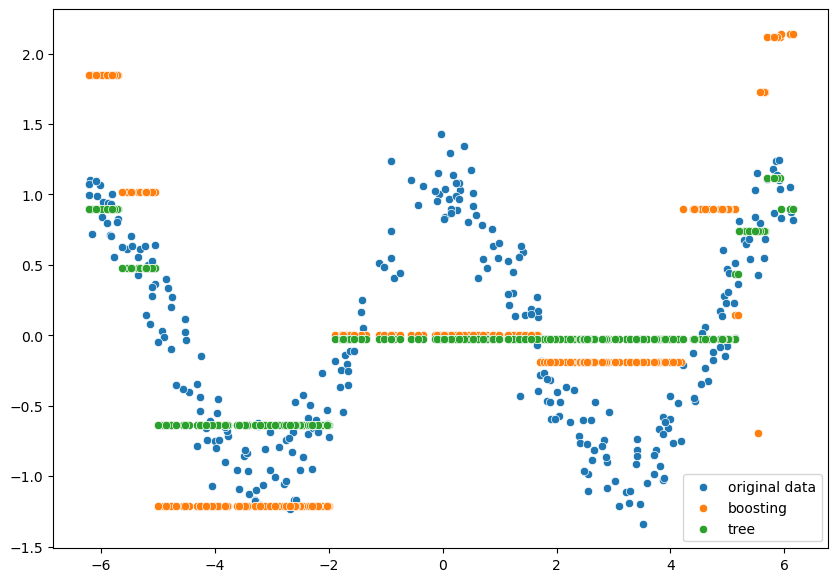

In [14]:
# генерируем данные
np.random.seed(42)
x = np.random.uniform(low=-2*np.math.pi, high=2*np.math.pi, size=(300))
y = np.cos(x) + np.random.randn(300) * 0.2

# обучаем обычное дерево глубины 3
tree = DecisionTreeRegressor(max_depth=3, random_state=42)
tree.fit(x.reshape(-1, 1), y)

# обучаем наш бустинг-ансамбль
clf = GradientTreeBoosting(iterations=3, max_depth=3, random_state=42)
clf.fit(x.reshape(-1, 1), y)

# визуализация
plt.figure(figsize=(10,7))
sns.scatterplot(x=x, y=y, label='original data')
sns.scatterplot(x=x, y=clf.predict(x.reshape(-1, 1)), label='boosting')
sns.scatterplot(x=x, y=tree.predict(x.reshape(-1, 1)), label='tree')

### Бустинг на практике: прогнозирование оттока пользователей из мобильной сети

Будем решать задачу классификации (sic!), предсказывая, уйдёт ли пользователь мобильной сети или нет.
Взято [отсюда](https://www.kaggle.com/mnassrib/telecom-churn-datasets).

Данные и их типы: 
- State: string
- Account length: integer 
- Area code: integer
- International plan: string
- Voice mail plan: string
- Number vmail messages: integer
- Total day minutes: double
- Total day calls: integer
- Total day charge: double
- Total eve minutes: double
- Total eve calls: integer
- Total eve charge: double
- Total night minutes: double
- Total night calls: integer
- Total night charge: double
- Total intl minutes: double
- Total intl calls: integer
- Total intl charge: double
- Customer service calls: integer
- Churn: string - целевой признак - уйдёт или нет (на самом деле pandas понимает его как булев)

Предсказывать будем логиты, то есть вероятность того, что клиент уйдёт, и на основе её уже делать прогноз, уйдёт ли он на самом деле или нет.

Вам предстоит самостоятельно провести эксперимент. Сравните качество нашей бустинг модели с обычными методами МО (вспомните и подумайте, какие лучше).

В качестве метрики качества используйте `f1_score` (а ещё лучше, `classification_report`).

#### Загрузите данные и предобработайте их.

Разбейте данные на тренировочную и тестовую подвыборки.

Поскольку деревья из sklearn не поддерживают категориальные признаки Вам придётся решить эту проблему - удалить их или обработать известными нам способами (one-hot-encoding, счётчики и тп).

В описании к датасету предполагалось использовать больший датасет(churn-bigml-80.csv) для обучения, а меньший(churn-bigml-20.csv) для проверки. 

In [17]:
### Ваш код ###
from sklearn.preprocessing import OneHotEncoder
# Загрузка и предобработка данных
df_train = pd.read_csv("../data/churn-bigml-80.csv")
df_test = pd.read_csv("../data/churn-bigml-20.csv")

# Преобразование категориальных признаков
ohe = OneHotEncoder(drop='first')
categorical_cols = ['State', 'International plan', 'Voice mail plan']
df_train_encoded = pd.get_dummies(df_train, columns=categorical_cols, drop_first=True)
df_test_encoded = pd.get_dummies(df_test, columns=categorical_cols, drop_first=True)

# Целевая переменная
y_train = df_train_encoded['Churn'].astype(int)
y_test = df_test_encoded['Churn'].astype(int)
X_train = df_train_encoded.drop(columns=['Churn'])
X_test = df_test_encoded.drop(columns=['Churn'])

Здесь я немного помогу Вам. Функция `test_qual` позволяет проверить качество классификации без лишних телодвижений. Воспользуйтесь ей (если хотите, можете модифицировать как Вам удобно). В исходном виде она не подойдёт для финальной проверки (на разных датасетах), но вы можете сделать промежуточные выводы на её основе.

In [22]:
def decide_class(logits, threshold=0.5):
    res = np.zeros(logits.shape[0])
    res[logits >= threshold] = 1
    return res

def test_qual(model, X, y, test_size=0.2, threshold=0.5):
    from sklearn.metrics import classification_report
    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True, random_state=42)

    model.fit(X_train, y_train)
    test_logits = model.predict(X_test)
    y_pred = decide_class(test_logits, threshold=threshold)

    #print(accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

In [23]:
# Запуск модели и оценка качества
clf = GradientTreeBoosting(iterations=50, max_depth=3, random_state=42)
test_qual(clf, X_train.values, y_train.values)


              precision    recall  f1-score   support

           0       0.85      1.00      0.92       455
           1       0.00      0.00      0.00        79

    accuracy                           0.85       534
   macro avg       0.43      0.50      0.46       534
weighted avg       0.73      0.85      0.78       534



c:\Users\lorex\anaconda3\envs\machine\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lorex\anaconda3\envs\machine\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lorex\anaconda3\envs\machine\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
